In [1]:
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy
import pyvisa as visa
import chipwhisperer as cw

TIMEOUT = 20000
TIMEOUT_SHORT = 200 # Used when running the acquisition loop and don't want to waste time on a missed trigger
TRACES = 1000
SCOPE_ADDR = "TCPIP0::192.168.1.140::inst0::INSTR"

def config_scope(scope: visa.resources.MessageBasedResource, display: bool = False, data_length: int = 12500):
	# Reset scope
	SESR = 0
	scope.write("*RST")
	scope.write("*CLS")
	scope.write("*OPC?")
	while SESR == 0:
		SESR = scope.read_stb()

	# Turn on/off waveform display
	scope.write(f"display:waveform {1 if display else 0}")

	# Enable channels 1 & 2
	scope.write("SELect:CH1 on")
	scope.write("*OPC?")
	while SESR == 0:
		SESR = scope.read_stb()
	scope.write("SELect:CH2 on")
	scope.write("*OPC?")
	while SESR == 0:
		SESR = scope.read_stb()
	scope.write("CH1:SCAle 0.01")
	scope.write("CH2:SCAle 1")

	# Set up the horizontal settings
	scope.write("HORizontal:MODe manual")
	scope.write("HORizontal:MODe:SAMPlerate 6.25e9")
	scope.write(f"HORizontal:MODe:RECOrdlength {data_length}")
	scope.write('HORizontal:SCAle 200e-9')
	scope.write('HORizontal:POSition 10')
	scope.write("*OPC?")
	while SESR == 0:
		SESR = scope.read_stb()

	# Set up the trigger
	scope.write("TRIGger:A:TYPe EDGE")
	scope.write("TRIGger:A:EDGE:SOURce CH2")
	scope.write("TRIGger:A:LEVEL:CH2 1.4")
	scope.write("TRIGger:A:EDGE:SLOPe RISE")
	scope.write("TRIGger:A:MODe NORMAL")
	scope.write("*OPC?")
	while SESR == 0:
		SESR = scope.read_stb()

	# Set up the scope to output binary data
	scope.write("WFMOutpre:ENCdg binary")
	scope.write("WFMOutpre:Bn_Fmt ri")
	scope.write("WFMOutpre:BYT_Or lsb")
	scope.write("WFMOutpre:BYT_Nr 2")
	scope.write("*OPC?")
	while SESR == 0:
		SESR = scope.read_stb()

	# Set up the scope to output the entire waveform
	scope.write("DATa:SOUrce CH1")
	scope.write("DATa:STARt 1")
	scope.write(f"DATa:STOP {data_length}")
	# Force a trigger to get the scope to update Nr_Pt and avoid cutting off future waveforms
	# While writing DATA above should be enough, it actually does not update the internal settings until a trace
	# is acquired. Too bad, these settings are NOT updated in CURVESTREAM mode, so in our case they'd never be changed.
	scope.write("TRIGger FORCe")
	assert int(scope.query("WFMOutpre:NR_Pt?").strip()) == data_length

	# Enable fast acquisition mode and curvestream
	scope.write("ACQuire:FASTAcq:STATE ON") # NOTE: Interestingly enough, if FASTAcq is not enabled the scope UI will DIE ON YOU. Clowntronix
	scope.write("CURVEStream?")
	time.sleep(3) # Just wait as there is no way to know when the scope is done setting up
	# As stated on the forums (https://forum.tek.com/viewtopic.php?p=281823#p281823):
	# "Note that *OPC? only works with *certain* long running commands on the instrument and not all commands on the instrument"

In [2]:
# Connect to the scope
rm = visa.ResourceManager()
scope: visa.resources.MessageBasedResource = rm.open_resource(SCOPE_ADDR) # type: ignore
scope.timeout = TIMEOUT

# Configure the target
# On the CW305, setting force=False only programs the FPGA if it is currently unprogrammed, whereas force=True programs the FPGA regardless.
# This option isn't available on the CW312T_A35 or CW312T_ICE40.
fpga_id = '100t'
target = cw.target(None, cw.targets.CW305, force=True, fpga_id=fpga_id)

# run at 10 MHz:
target.pll.pll_outfreq_set(10E6, 1)

# Finally acquire data from the scope
Note: If you see many timeouts/duplicate traces (as in 50%), you may need to check whether the trace length is sensible. Sometimes it is set to 1?

In [3]:
# Configure the scope
scope.timeout = TIMEOUT
config_scope(scope, display=False)
print("Scope configured")

wfm_byte_order = scope.query("WFMOutpre:BYT_Or?").strip().lower()
wfm_byte_nr = int(scope.query("WFMOutpre:BYT_Nr?").strip())
wfm_byte_format = scope.query("WFMOutpre:Bn_Fmt?").strip().lower()
types = { # Got these from the programmer manual § WFMOutpre:BN_Fmt
    1: {'ri': 'b', 'rp': 'B'},
    2: {'ri': 'h', 'rp': 'H'},
    4: {'ri': 'i', 'rp': 'I', 'fp': 'f'},
    8: {'ri': 'q', 'rp': 'Q', 'fp': 'd'},
}

traces = []
scope.timeout = TIMEOUT_SHORT # Reduce timeout here in case we miss a trigger
start = time.time()
for i in tqdm(range(TRACES)):
    target.simpleserial_write('p', b'\x00' * 16)
    response = target.simpleserial_read('r', target.output_len, ack=True)
    # Decomment this to emulate a single missed trigger and see if the checks below work
    # if i != 32:
    #     target.simpleserial_write('p', b'\x00' * 16)
    #     response = target.simpleserial_read('r', target.output_len, ack=True)
    try:
        trace = scope.read_binary_values(datatype=types[wfm_byte_nr][wfm_byte_format], is_big_endian=(wfm_byte_order == 'msb'))
    except visa.errors.VisaIOError as e:
        if e.error_code == visa.constants.VI_ERROR_TMO:
            print("Timeout occurred")
            # Reinit curvestream
            scope.write("*CLS")
            scope.write("CURVEStream?")
            continue
    if traces and trace == traces[-1]:
        # This should never happen because the scope send buffer is always cleared on a read, but...
        print("Duplicate trace detected")
    traces.append(trace)
scope.timeout = TIMEOUT # Reset timeout
end = time.time()
print(f"Captured {len(traces)} traces in {end - start} seconds")

scope.write("*RST")
scope.write("*CLS")

Scope configured


  0%|          | 0/1000 [00:00<?, ?it/s]

Timeout occurred
Captured 999 traces in 132.86675119400024 seconds


6

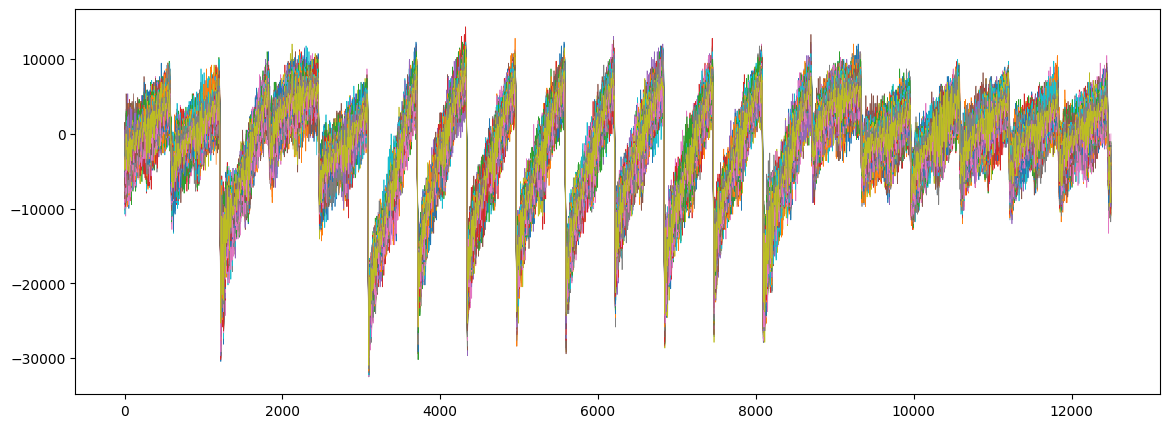

In [4]:
plt.figure(1, figsize=(14, 5)) # Make it look similar to the scope
for trace in traces:
	plt.plot(trace, linewidth=.5, markersize=5)